# Featureset evaluation
Evaluation of different featuresets for all algorithms.

## Preparation
- Imports
- Data preprocessing
- Target encoding

In [1]:
from pandas import DataFrame
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)

df = pd.read_csv('../0_data/DEvideos.csv',
    low_memory=False)

df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
df['publish_month'] = df['publish_time'].map(lambda x: x.month)
df['publish_year'] = df['publish_time'].map(lambda x: x.year)
df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

df['ratings'] = df['likes'] + df['dislikes']
df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
df['ratings_per_view'] = df['ratings'] / df['views']
df['comments_per_view'] = df['comment_count'] / df['views']

def assign_target_category(row):
    if row['days_until_trending'] == 0: 
        return 0
    elif row['days_until_trending'] == 1:
        return 1
    elif row['days_until_trending'] == 2:
        return 2
    elif row['days_until_trending'] <= 5:
        return 3
    else:
        return 6

df['target_category'] = df.apply(assign_target_category, axis=1)
df['channel_title'] = df['channel_title'].astype('category')

tag_df = pd.read_csv('../0_data/DEtags.csv')
tag_df = tag_df.set_index('tag')
def calculate_tag_factor(tag_string, tag_data):
    tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
    return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)
    
df['tag_factors'] = df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
df['tag_factors'] = df.apply(lambda row: 0 if np.isnan(row['tag_factors']) else row['tag_factors'], axis=1)

N = len(df)
dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
for column in df.columns:
    numberOfUniqueValues = df[column].nunique()
    if numberOfUniqueValues < 2:
        dropColumns.append(column)
    elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
        dropColumns.append(column)
    elif df[column].isna().sum() / N > 0.95:
        dropColumns.append(column)
        
df.drop(columns=dropColumns, inplace=True)

target = df['target_category'].astype(str)
y_label_encoder = preprocessing.LabelEncoder()
y_label_encoder.fit(target)
y = y_label_encoder.transform(target)

## Declare classifiers
A list of the classification algorithms that will be applied and compared. The optimized variants of the classification algorithms receive the parameters determined in the [optimization notebook](https://github.com/StephanHagge/data-mining/blob/master/4_modeling/model_optimization.ipynb). The maximized variants of the algorithms were derived as part of the evaluations of the number of [neighbors](https://github.com/StephanHagge/data-mining/blob/master/5_evaluation/neighbors_evaluation.ipynb), [estimators](https://github.com/StephanHagge/data-mining/blob/master/5_evaluation/estimators_evaluation.ipynb) and [maximum tree depth](https://github.com/StephanHagge/data-mining/blob/master/5_evaluation/depth_evaluation.ipynb).

In [2]:
classifiers = []

classifiers.append(['Decision Tree', DecisionTreeClassifier()])
classifiers.append(['K Nearest Neighbor', KNeighborsClassifier(n_jobs=-1)])
classifiers.append(['Random Forest', RandomForestClassifier(n_jobs=-1)])
classifiers.append(['XG Boost', XGBClassifier(use_label_encoder=False, verbosity=0)])
classifiers.append(['SVM', SVC(kernel='rbf', random_state = 1)])

classifiers.append(['Decision Tree (optimized)', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=50, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, splitter='best')])
classifiers.append(['K Nearest Neighbor (optimized)', KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree', leaf_size=20, n_neighbors=8, p=1, weights='uniform')])
classifiers.append(['Random Forest (optimized)', RandomForestClassifier(n_jobs=-1, class_weight=None, criterion='gini', max_depth=9, max_features='log2', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=200)])
classifiers.append(['XG Boost (optimized)', XGBClassifier(use_label_encoder=False, verbosity=0, booster='gbtree', colsample_bylevel=0.75, colsample_bynode=1, colsample_bytree=1, gamma=2, learning_rate=0.5, max_delta_step=0, max_depth=6, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=0, subsample=1, tree_method='hist')])

classifiers.append(['K Nearest Neighbor (maxed)', KNeighborsClassifier(n_jobs=-1, n_neighbors=300)])
classifiers.append(['Random Forest (maxed) 1', RandomForestClassifier(n_jobs=-1, max_depth=18, n_estimators=200)])
classifiers.append(['Random Forest (maxed) 2', RandomForestClassifier(n_jobs=-1, max_depth=18, n_estimators=1000)])

## Iterate over featuresets
Iteration over the various feature sets. These are continuously increasing in scope.

In [3]:
%%time
featuresets = [['tag_factors'],
['views', 'publish_hour'],
['views', 'publish_hour', 'tag_factors'],
['views', 'publish_hour', 'ratings_per_view'],
['views', 'publish_hour', 'ratings_per_view', 'tag_factors'],
['views', 'publish_hour', 'ratings_per_view', 'comments_per_view'],
['views', 'publish_hour', 'ratings_per_view', 'comments_per_view', 'tag_factors']]

def join_features(featureset):
    jf = ''
    for feature in featureset:
        jf += feature[:1] + ','
    return jf[:-1]

results = pd.DataFrame(columns=['algorithm', 'accuracy', 'execution_time', 'featureset'])

for featureset in featuresets:
    # Encode features
    x_df = DataFrame(index=df.index)
    for feature in featureset:
        feature_data = df[feature]
        if df[feature].dtype.name == 'category':
            x_label_encoder = preprocessing.LabelEncoder()
            x_label_encoder.fit(feature_data.astype(str))
            x_df[feature] = x_label_encoder.transform(feature_data)
        elif df[feature].dtype.name == 'datetime64[ns]':
            x_df[feature] = feature_data.to_seconds()
        elif df[feature].dtype.name == 'bool':
            x_df[feature] = int(feature_data)
        else:
            x_df[feature] = feature_data

    x = np.reshape(x_df, (-1, len(x_df.columns)))

    # Create data subsets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=0)

    # Train model and predict test data
    for classifier in classifiers:
        start_time = time.time()
        classifier[1].fit(x_train, y_train)
        y_pred = classifier[1].predict(x_test)
        execution_time = time.time() - start_time
        result = {'algorithm': classifier[0], 'accuracy': accuracy_score(y_test, y_pred), 'execution_time': execution_time, 'featureset': join_features(featureset)}
        results = results.append(result, ignore_index=True)

Wall time: 6min 19s


## Results
In the following, the results of the various algorithms are examined in various visualizations.

*The names of the features have been abbreviated in the x-axis of the graph for a clearer representation.*

**featureset**:
- ``t``: tag_factors
- ``v``: views
- ``p``: publish_hour
- ``r``: ratings_per_view
- ``c``: comments_per_view

In [4]:
results.head(15)

,algorithm,accuracy,execution_time,featureset
0,Decision Tree,0.511508,0.046999,t
1,K Nearest Neighbor,0.575661,0.388001,t
2,Random Forest,0.508142,0.419001,t
3,XG Boost,0.612329,2.382178,t
4,SVM,0.622245,30.182314,t
5,Decision Tree (optimized),0.619001,0.022000,t
6,K Nearest Neighbor (optimized),0.590047,0.416003,t
7,Random Forest (optimized),0.618205,0.567002,t
8,XG Boost (optimized),0.620225,0.581001,t
9,K Nearest Neighbor (maxed),0.621388,0.759001,t


### Default and optimized
At the beginning, the results of all algorithms are placed in their standard configuration and with optimized parameters in a common context. It is noticeable that tree-based algorithms react particularly harshly to the lack of the tag factor feature, while KNN and SVM stand out due to their high robustness, almost ignorance, towards an extended feature set.

#### Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

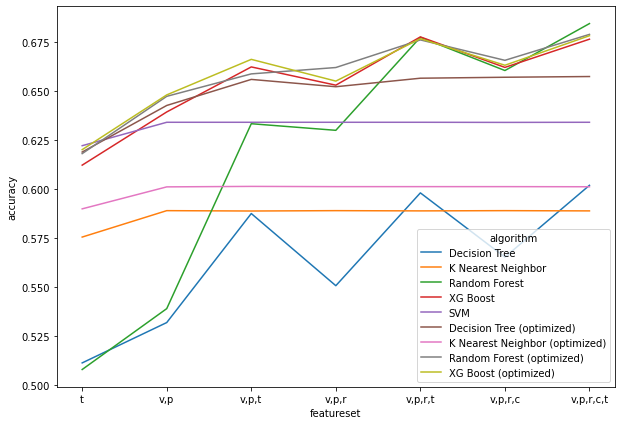

In [5]:
sns.lineplot(data=results[results['algorithm'].str.contains('(maxed)') == False], x='featureset', y='accuracy', hue='algorithm')

#### Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

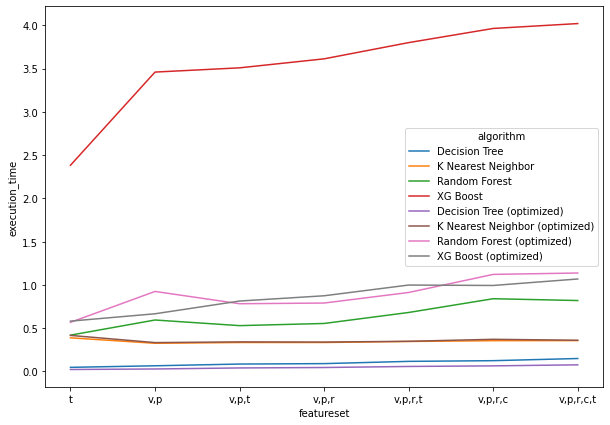

In [6]:
results_not_svm = results[results['algorithm'].str.contains('SVM') == False]
sns.lineplot(data=results_not_svm[results_not_svm['algorithm'].str.contains('(maxed)') == False], x='featureset', y='execution_time', hue='algorithm')

The comparison of the execution time of all with the support vector machine classification (SVM / SVC) is considered separately in order to show the differences between the remaining algorithms in more detail in the previous graph. SVM impresses with its unhealthy computing time requirements.

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

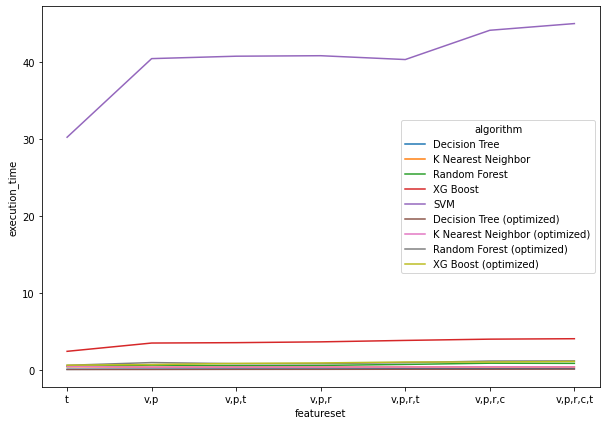

In [7]:
sns.lineplot(data=results[results['algorithm'].str.contains('(maxed)') == False], x='featureset', y='execution_time', hue='algorithm')

### Decision tree
With the decision tree algorithm, it is noteworthy that the optimized variant has a consistently higher level of accuracy and robustness against changes to the feature set, while at the same time requiring significantly less computing time.

#### Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

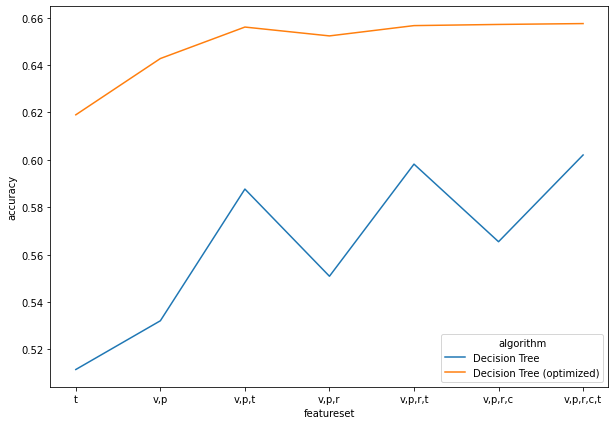

In [8]:
results_dt = results[results['algorithm'].str.contains('Decision Tree')]
sns.lineplot(data=results_dt, x='featureset', y='accuracy', hue='algorithm')

#### Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

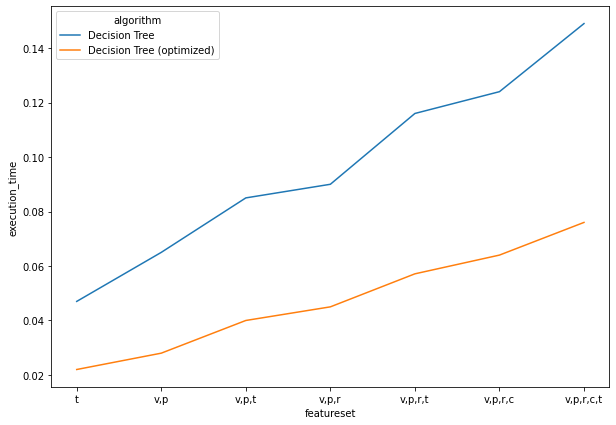

In [9]:
sns.lineplot(data=results_dt, x='featureset', y='execution_time', hue='algorithm')

### K nearest neigbour
The K nearest neighbor algortihmus impresses with stagnaz at a low level. The high gain in accuracy of the maximized variant is paid for by an even greater increase in computing time.

#### Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

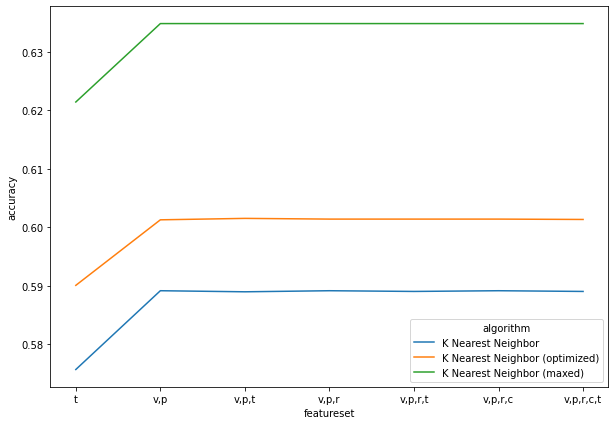

In [10]:
results_knn = results[results['algorithm'].str.contains('K Nearest Neighbor')]
sns.lineplot(data=results_knn, x='featureset', y='accuracy', hue='algorithm')

#### Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

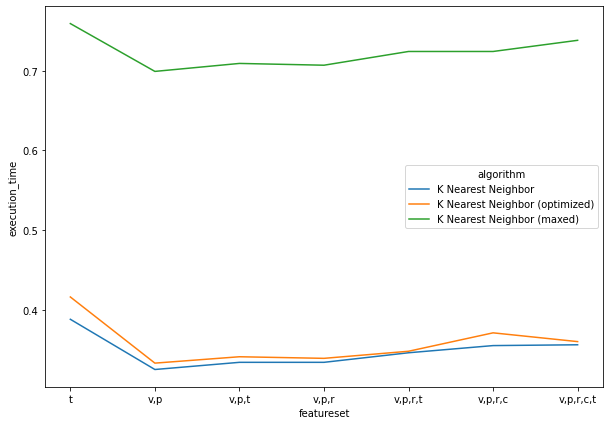

In [11]:
sns.lineplot(data=results_knn, x='featureset', y='execution_time', hue='algorithm')

### Random forest
The Random Forest reacts particularly strongly to the tag factors. The optimized variant has more robustness and a significantly higher accuracy with a narrow feature set, but has a disadvantage with a wide feature set and requires more computing time across the board.
The maximized variant one consistently beats the standard variant in terms of accuracy, but requires significantly more computing time. The second maximized variant has a higher number of estimators, but produces almost exactly the same results as the previous variant and at the same time takes an extremely increased amount of time.

#### Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

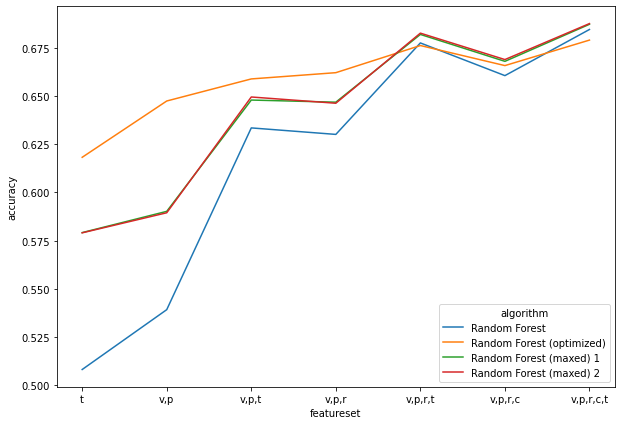

In [12]:
results_rf = results[results['algorithm'].str.contains('Random Forest')]
sns.lineplot(data=results_rf, x='featureset', y='accuracy', hue='algorithm')

#### Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

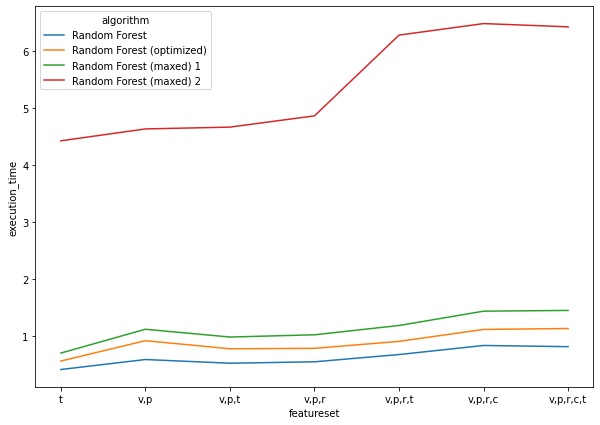

In [13]:
sns.lineplot(data=results_rf, x='featureset', y='execution_time', hue='algorithm')

### XG Boost
XG Boost also reacts strongly to the tag factors. The optimized variant can consistently reproduce the accuracy of the standard variant relatively precisely, and is usually somewhat better. At the same time, it requires much less computing time.

#### Accuracy

<AxesSubplot:xlabel='featureset', ylabel='accuracy'>

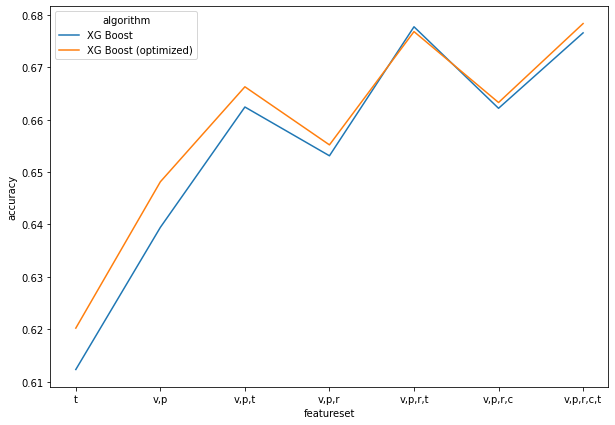

In [14]:
results_xgb = results[results['algorithm'].str.contains('XG Boost')]
sns.lineplot(data=results_xgb, x='featureset', y='accuracy', hue='algorithm')

#### Execution time

<AxesSubplot:xlabel='featureset', ylabel='execution_time'>

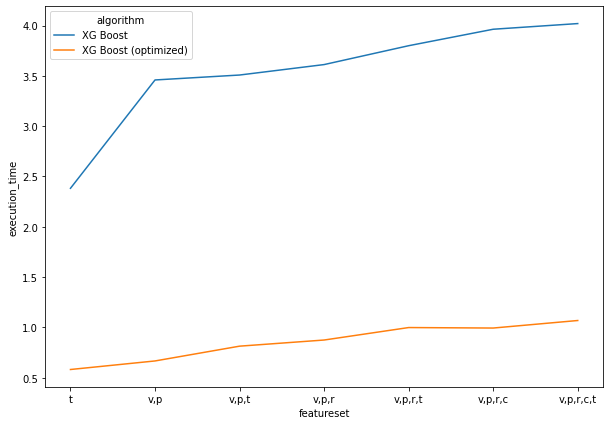

In [15]:
sns.lineplot(data=results_xgb, x='featureset', y='execution_time', hue='algorithm')

### SVM
The support vector machine classification is the special kid in the sandpit. After receiving the second feature, it stagnates at a comparatively mediocre level. While the same robustness paired with better accuracy compared to the KNN could be considered as an argument, the computing time required is in no way justifiable. An optimized decision tree requires only about a thousandth of the computing time for about three percent higher accuracy.

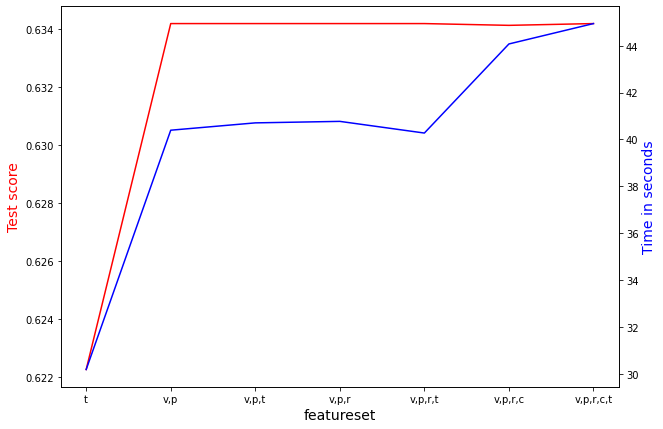

In [18]:
results_svm = results[results['algorithm'].str.contains('SVM')]

fig,ax = plt.subplots()
ax.plot(results_svm.featureset, results_svm.accuracy, color="red")
ax.set_xlabel("featureset", fontsize=14)
ax.set_ylabel("Test score", color="red", fontsize=14)

ax2=ax.twinx()
ax2.plot(results_svm.featureset, results_svm.execution_time, color="blue")
ax2.set_ylabel("Time in seconds", color="blue", fontsize=14)

plt.show()